# Project: Evaluation of the Performance of Single Index Model (SIMs)
Now that we understand how to estimate single-index models, we will use them in upcoming lessons on portfolio allocation and decision-making. However, there are still unanswered questions about single-index models. For instance, do these models maintain the statistical properties of returns, also known as stylized facts? Additionally, can the predicted return for a specific stock using a single-index model be considered representative of the actual observed return for that stock? In other words, we need to test if single-index models are a reliable predictive tool.

### Learning objectives
In this project, we'll calculate the statistical properties of historical return data and compare them to properties calculated using single index models. First, we'll compute the excess returns for all tickers and filter out the excess return for `SPY.` Then, we'll calculate the excess return distributions of the single-index models and compare them with historical data.

* __Prerequisites__: we'll begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `10-31-2023`. We'll clean the data and compute the excess return for all tickers in the dataset, including `SPY` (our `market` portfolio).
* __Task 1__: Then, we'll compute the excess return distribution for all single index models in our collection and visualize the data's return distribution versus the single index model.
* __Task 2__: Finally, we'll develop tests to compute the similarity of the `data` versus `single-index` return distributions and compare some statistical properties.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-3/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-3`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-3/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-135/module-3/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Let's get a list of firms that we have in cleaned up `dataset`, and save it in the `all_tickers` array

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

### Compute the covariance, correlation, and expected return for all firms in the dataset
The expected growth $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll need to compute values for both of these quantities for the entire data set (all `N = 459` tickers), and then we'll filter out which tickers we are interested in. 

* First, we specify a value for the `risk_free_rate` variable.

In [13]:
risk_free_rate = 0.05;

* Then we compute the expected (annualized) excess log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [15]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_all_tickers, Δt = (1.0/252.0), 
    risk_free_rate = risk_free_rate);

* Next, we estimate the expected return for each firm from the `all_firms_return_matrix` using the `mean(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(r_{1}),\dotsc,\mathbb{E}(r_{N})$ to the array $\mu$:

In [17]:
μ = mean(all_firms_excess_return_matrix, dims=1) |> vec;

* Estimate the annualized `covariance_matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the `cov(...)` function, exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $\Sigma$ variable:

In [19]:
Σ = cov(all_firms_excess_return_matrix) |> x-> x*(1/252) # annualized, historical volatility

460×460 Matrix{Float64}:
 0.0655367  0.0409146  0.0273076  …  0.0444449  0.0343089  0.0362875
 0.0409146  0.283809   0.0573645     0.069817   0.0986843  0.0383996
 0.0273076  0.0573645  0.12501       0.0392735  0.0510524  0.0292667
 0.0323065  0.0444841  0.0236737     0.045334   0.0268079  0.0336129
 0.0198861  0.0206277  0.0201981     0.0175898  0.0216887  0.0225977
 0.0317812  0.0228434  0.0180639  …  0.0300955  0.0202344  0.0301296
 0.0345523  0.0475915  0.0321036     0.0448403  0.0392157  0.0353211
 0.0387532  0.0358116  0.0245768     0.0519358  0.023438   0.0383791
 0.0383595  0.063833   0.0295398     0.055052   0.0425233  0.033446
 0.0209082  0.047045   0.0262508     0.0282589  0.0450202  0.0181709
 0.028523   0.0471555  0.0297807  …  0.0372987  0.0362684  0.030892
 0.0483308  0.0647852  0.0352406     0.0650439  0.041227   0.0429126
 0.0167745  0.0184331  0.0190468     0.0163051  0.0187535  0.0207827
 ⋮                                ⋱                        
 0.0225894  0.054666

* Estimate the annualized `correlation matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the [cor(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor), exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ correlation matrix in the $ρ$ variable:

In [21]:
ρ = cor(all_firms_excess_return_matrix) # correlation matrix

460×460 Matrix{Float64}:
 1.0       0.300001  0.301695  0.479962  …  0.48165   0.333841  0.581071
 0.300001  1.0       0.304549  0.317579     0.36358   0.461435  0.29548
 0.301695  0.304549  1.0       0.254655     0.308162  0.359682  0.339325
 0.479962  0.317579  0.254655  1.0          0.47834   0.253979  0.52406
 0.304411  0.151737  0.223867  0.267654     0.191234  0.211721  0.363022
 0.5611    0.193803  0.230915  0.446208  …  0.37737   0.227813  0.55824
 0.557203  0.368804  0.374852  0.577663     0.51357   0.403288  0.597762
 0.497469  0.220908  0.22843   0.592591     0.473501  0.191866  0.517024
 0.534947  0.427773  0.298274  0.565422     0.545263  0.378167  0.489485
 0.352345  0.380973  0.320304  0.31355      0.338222  0.483813  0.321355
 0.486248  0.3863    0.367593  0.481361  …  0.451597  0.394284  0.55267
 0.547685  0.352786  0.289148  0.542806     0.523489  0.297925  0.510328
 0.312193  0.164855  0.256664  0.290533     0.215522  0.222574  0.405913
 ⋮                            

## Task 1: Compute the excess annual return the for single-index models in our collection

First, load the single index model file generated in this module's `worked example`. Save the collection of models in the `sim_model_dictionary::Dict{String, MySingleIndexModel}` dictionary.

In [24]:
sim_model_dictionary = load(joinpath(_PATH_TO_DATA,"SIMs-SP500-01-03-18-to-12-29-23.jld2")) |> x-> x["sim"] 

Dict{String, MySingleIndexModel} with 460 entries:
  "NI"   => MySingleIndexModel(-0.0709741, 0.652999, 0.05, Normal{Float64}(μ=1.…
  "EMR"  => MySingleIndexModel(-0.0523764, 1.23526, 0.05, Normal{Float64}(μ=-1.…
  "CTAS" => MySingleIndexModel(0.121408, 1.17936, 0.05, Normal{Float64}(μ=2.298…
  "HSIC" => MySingleIndexModel(-0.0820776, 0.913675, 0.05, Normal{Float64}(μ=1.…
  "KIM"  => MySingleIndexModel(-0.0786588, 1.28859, 0.05, Normal{Float64}(μ=-6.…
  "PLD"  => MySingleIndexModel(0.0276239, 1.02836, 0.05, Normal{Float64}(μ=-1.4…
  "IEX"  => MySingleIndexModel(-0.0098079, 0.963259, 0.05, Normal{Float64}(μ=-1…
  "BAC"  => MySingleIndexModel(-0.0885823, 1.32778, 0.05, Normal{Float64}(μ=-6.…
  "CBOE" => MySingleIndexModel(-0.0143917, 0.588498, 0.05, Normal{Float64}(μ=3.…
  "EXR"  => MySingleIndexModel(0.0222396, 0.725388, 0.05, Normal{Float64}(μ=1.0…
  "NCLH" => MySingleIndexModel(-0.321969, 2.32891, 0.05, Normal{Float64}(μ=1.12…
  "CVS"  => MySingleIndexModel(-0.0727375, 0.78292, 0.05, 

Next, we need to pull out the excess return of the `market portfolio` from `all_firms_excess_return_matrix`. To do this, look up the index for our market portfolio surrogate `SPY,` then get this column of data from the `all_firms_excess_return_matrix.` We'll store the excess return data for `SPY` in the `Rₘ` variable:

In [26]:
Rₘ = findfirst(x->x=="SPY", list_of_all_tickers) |> i -> all_firms_excess_return_matrix[:,i];

Fill me in. Not sure what is going on

In [78]:
excess_return_sims = Array{Float64,2}(undef, length(sim_model_dictionary), length(Rₘ));
for i ∈ eachindex(list_of_all_tickers)

    sim_model_ticker = list_of_all_tickers[i] |> ticker -> sim_model_dictionary[ticker];
    α = sim_model_ticker.α
    β = sim_model_ticker.β
    ϵ = sim_model_ticker.ϵ
    R_ticker = sim_model_ticker(sort(Rₘ), 100) |> x-> mean(x,dims=2)

    for j ∈ eachindex(Rₘ)
       excess_return_sims[i,j] = R_ticker[j] 
    end
end
excess_return_sims;

### TODO: Visualize the return distribution of your ticker of choice
Fill me in

In [95]:
ticker_to_visualize = "QQQ";

`Unhide` the code block below to see how we plotted the simulated and observed growth rate, i.e., scaled return for your `ticker_to_visualize` se

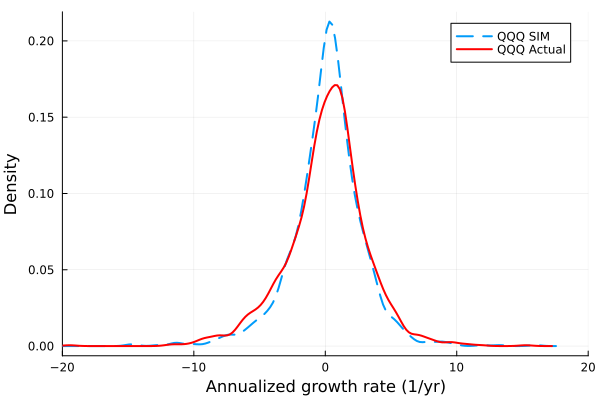

In [91]:
let
    index_to_visualize = findfirst(x->x==ticker_to_visualize, list_of_all_tickers)
    density(excess_return_sims[index_to_visualize,:], lw=2, 
        label="$(ticker_to_visualize) SIM", ls=:dash)
    density!(all_firms_excess_return_matrix[:,index_to_visualize], 
        c=:red, xlims=(-20.0,20.0), label="$(ticker_to_visualize) Actual", 
            xlabel="Annualized growth rate (1/yr)", ylabel="Density", lw=2)
end

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.